In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

### Examine Training Data:

Using downloaded and verified file: ./data/train_32x32.mat


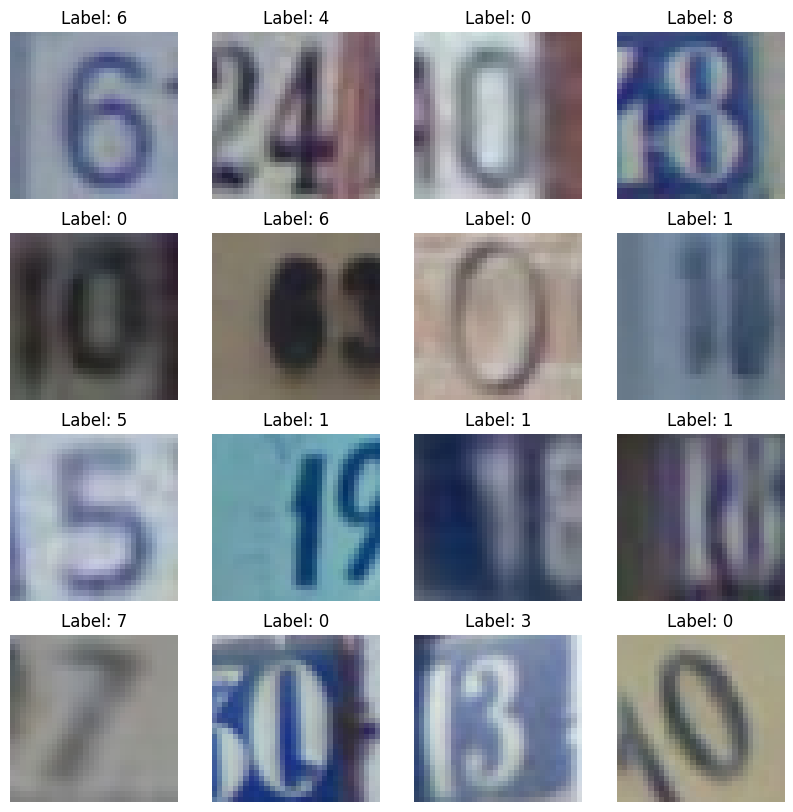

In [2]:
untransformed_dataset = datasets.SVHN(root='./data', split='train', download=True)
random_indices = np.random.choice(len(untransformed_dataset), size=16, replace=False)

# Plot 16 random images from training
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices, 1):
    image, label = untransformed_dataset[idx]
    plt.subplot(4, 4, i)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

### Download and transform data:

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),      # Resize to a common size
    transforms.ToTensor(),             # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to the range [-1, 1] for CNN
])
train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
test_dataset = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [4]:
train_dataset

Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
test_dataset

Dataset SVHN
    Number of datapoints: 26032
    Root location: ./data
    Split: test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

### Create Dataloaders for CNN Implementations:

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Basic CNN Implementation for SVHN:

In [7]:
class Basic_CNN(nn.Module):
    def __init__(self):
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for digits 0-9

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  # Flatten the output from conv layers
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Training:

In [8]:
# Initialize the model, loss function, and optimizer
model_cnn = Basic_CNN()
criterion_cnn = nn.CrossEntropyLoss()
#optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.0001)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001) #better performing

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model_cnn.train()

    for images, labels in train_loader:
        optimizer_cnn.zero_grad()
        outputs = model_cnn(images)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}')
print("Training Finished!")

# Save the entire model
torch.save(model_cnn, 'models/basic_cnn.pth')

Epoch 1/10, Training Loss: 0.5013821721076965
Epoch 2/10, Training Loss: 0.5884568095207214
Epoch 3/10, Training Loss: 0.44566118717193604
Epoch 4/10, Training Loss: 0.22768384218215942
Epoch 5/10, Training Loss: 0.39363792538642883
Epoch 6/10, Training Loss: 0.11251845210790634
Epoch 7/10, Training Loss: 0.20888395607471466
Epoch 8/10, Training Loss: 0.28878694772720337
Epoch 9/10, Training Loss: 0.3216472864151001
Epoch 10/10, Training Loss: 0.08385274559259415
Training Finished!


#### Testing and Analysis:

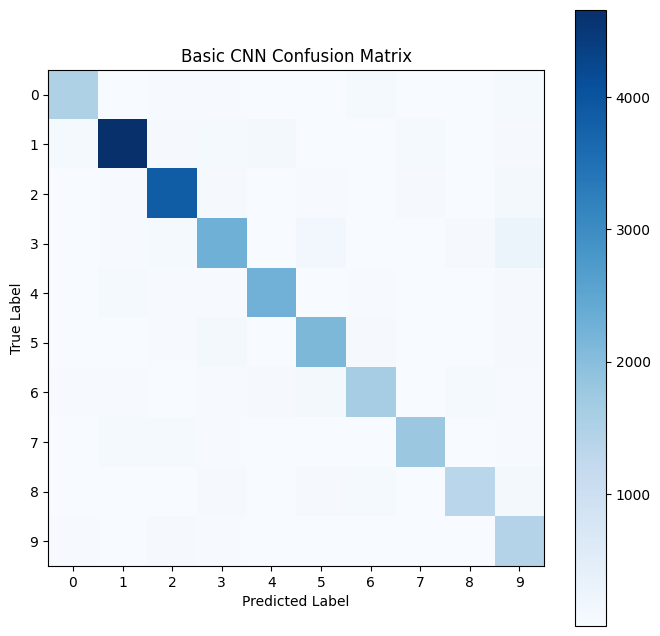

Basic CNN Test Accuracy: 87.68%


In [9]:
#Load the model
model_basic_cnn = torch.load('models/basic_cnn.pth')

# Set the model to evaluation mode
model_basic_cnn.eval()

# Initialize variables for misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

# Initialize variables for accuracy and predictions
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        outputs = model_basic_cnn(images)
        
        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        
        # Append true labels and predictions to lists
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

        # Find misclassified indices
        incorrect_indices = (predicted != labels).nonzero().squeeze()
        
        # Collect misclassified images, true labels, and predictions
        for idx in incorrect_indices:
            misclassified_images.append(images[idx])
            misclassified_labels.append(labels[idx].item())
            misclassified_predictions.append(predicted[idx].item())

# Generate and display confusion matrix
class_names = ['0','1','2','3','4','5','6','7','8','9']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Basic CNN Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('results/Confusion_BasicCNN.png')

plt.show()

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Basic CNN Test Accuracy: {accuracy * 100:.2f}%')

#### Examine misclassified images:

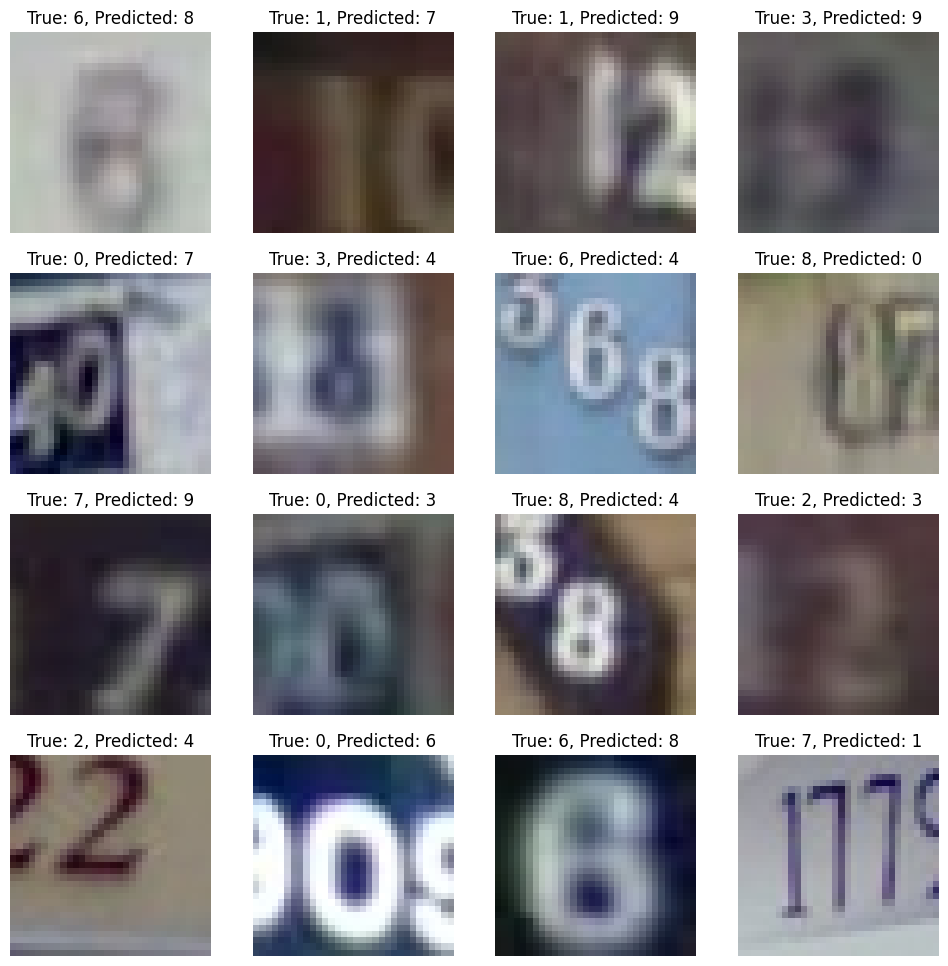

In [10]:
num_images_to_display = min(16, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), size=num_images_to_display, replace=False)

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
    transforms.ToPILImage()
])

# Display the images
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices, 1):
    image = misclassified_images[idx]
    true_label = misclassified_labels[idx]
    predicted_label = misclassified_predictions[idx]

    plt.subplot(4, 4, i)
    plt.imshow(inv_transform(image))
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')

plt.savefig('results/Error_Examples_BasicCNN.png')
plt.show()

### LeNet Implementation for SVHN:

In [11]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

#### Training:

In [12]:
# Initialize the model, loss function, and optimizer
model_lenet = LeNet()
criterion_lenet = nn.CrossEntropyLoss()
#optimizer_lenet = optim.Adam(model_lenet.parameters(), lr=0.0001)
optimizer_lenet = optim.Adam(model_lenet.parameters(), lr=0.001) #better performing

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model_lenet.train()

    for images, labels in train_loader:
        optimizer_lenet.zero_grad()
        outputs = model_lenet(images)
        loss = criterion_lenet(outputs, labels)
        loss.backward()
        optimizer_lenet.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}')
print("Training Finished!")

# Save the entire model
torch.save(model_cnn, 'models/LeNet_cnn.pth')

Epoch 1/10, Training Loss: 0.5350453853607178
Epoch 2/10, Training Loss: 0.42019057273864746
Epoch 3/10, Training Loss: 0.08607377111911774
Epoch 4/10, Training Loss: 0.8341495990753174
Epoch 5/10, Training Loss: 0.18434232473373413
Epoch 6/10, Training Loss: 0.4852912127971649
Epoch 7/10, Training Loss: 0.40193524956703186
Epoch 8/10, Training Loss: 0.18431931734085083
Epoch 9/10, Training Loss: 0.1279550939798355
Epoch 10/10, Training Loss: 0.38096827268600464
Training Finished!


#### Testing and Analysis

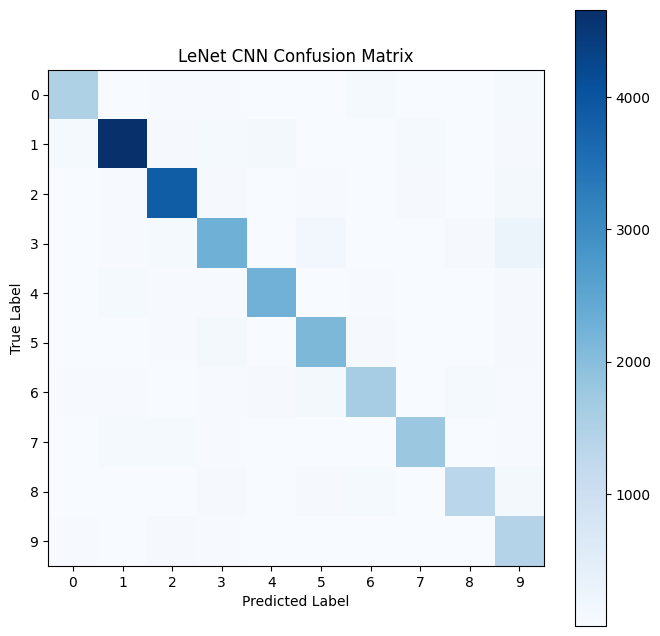

LeNet Test Accuracy: 87.68%


In [13]:
#Load the model
model_lenet = torch.load('models/LeNet_cnn.pth')

# Set the model to evaluation mode
model_lenet.eval()

# Initialize variables for misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

# Initialize variables for accuracy and predictions
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        outputs = model_lenet(images)
        
        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        
        # Append true labels and predictions to lists
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

        # Find misclassified indices
        incorrect_indices = (predicted != labels).nonzero().squeeze()
        
        # Collect misclassified images, true labels, and predictions
        for idx in incorrect_indices:
            misclassified_images.append(images[idx])
            misclassified_labels.append(labels[idx].item())
            misclassified_predictions.append(predicted[idx].item())

# Generate and display confusion matrix
class_names = ['0','1','2','3','4','5','6','7','8','9']
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('LeNet CNN Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('results/Confusion_LeNet.png')

plt.show()

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'LeNet Test Accuracy: {accuracy * 100:.2f}%')

#### Examine Misclassified Images:

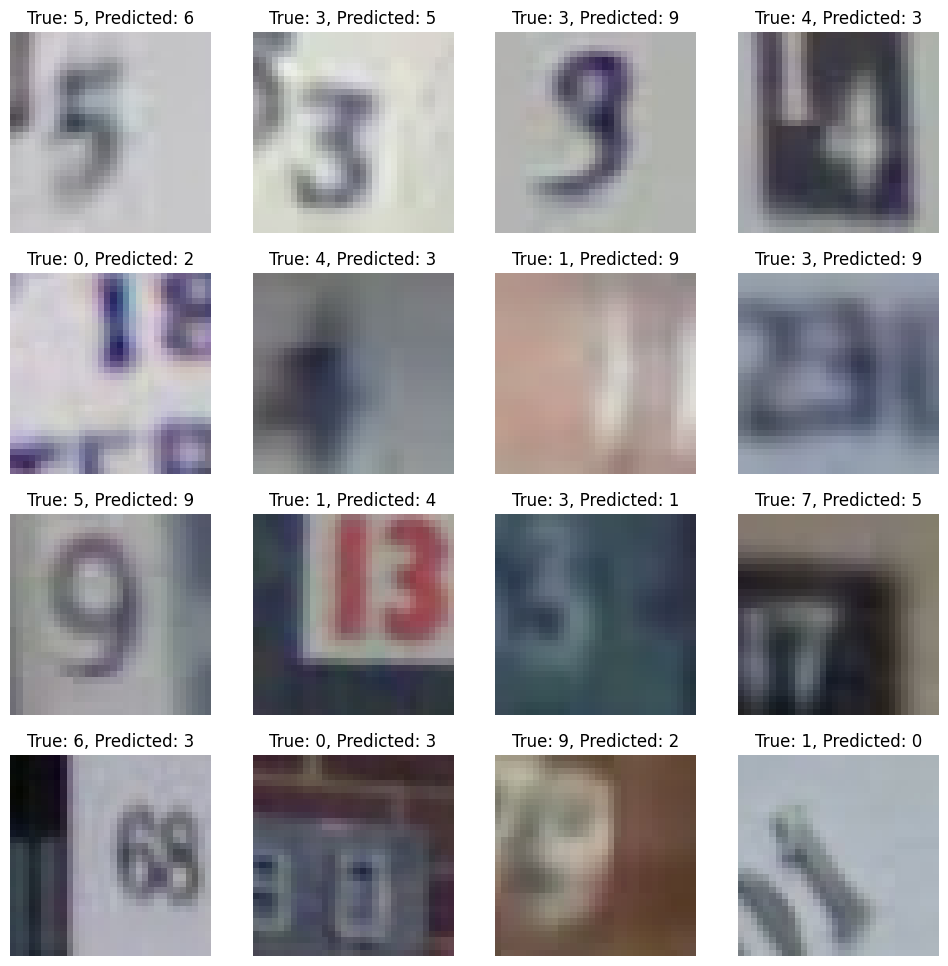

In [14]:
num_images_to_display = min(16, len(misclassified_images))
random_indices = np.random.choice(len(misclassified_images), size=num_images_to_display, replace=False)

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),
    transforms.ToPILImage()
])

# Display the images
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_indices, 1):
    image = misclassified_images[idx]
    true_label = misclassified_labels[idx]
    predicted_label = misclassified_predictions[idx]

    plt.subplot(4, 4, i)
    plt.imshow(inv_transform(image))
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')

plt.savefig('results/Error_Examples_LeNet.png')
plt.show()

### A Note on AlexNet:
We originally considered trying an implementation of AlexNet however since AlexNet is designed for larger images (224x224), we would have to upscale our house number images which are currently 32x32. Upscaling our images could introduce artifacts and wouldn't necessarily improve the performance of AlexNet which is designed for larger image sizes. In fact, we think that it's likely to result in a loss of information and degrade performance.